In [1]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
sleep = sqlContext.read.json("s3a://insight-spark-fitbit/sleep.txt")
sleep.printSchema()

root
 |-- sleep: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- awakeCount: long (nullable = true)
 |    |    |-- awakeDuration: long (nullable = true)
 |    |    |-- awakeningsCount: long (nullable = true)
 |    |    |-- dateOfSleep: string (nullable = true)
 |    |    |-- duration: long (nullable = true)
 |    |    |-- efficiency: long (nullable = true)
 |    |    |-- isMainSleep: boolean (nullable = true)
 |    |    |-- logId: long (nullable = true)
 |    |    |-- minuteData: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- dateTime: string (nullable = true)
 |    |    |    |    |-- value: string (nullable = true)
 |    |    |-- minutesAfterWakeup: long (nullable = true)
 |    |    |-- minutesAsleep: long (nullable = true)
 |    |    |-- minutesAwake: long (nullable = true)
 |    |    |-- minutesToFallAsleep: long (nullable = true)
 |    |    |-- restlessCount: long (nullable = true)
 |

In [3]:
sleep.persist(StorageLevel.MEMORY_AND_DISK_SER)
sleep.registerTempTable("sleep")

In [4]:
sleeps = sqlContext.sql("""
    SELECT explode(sleep) as sleep
    FROM sleep
""")
sleeps.registerTempTable("sleeps")
sleeps.printSchema()

summaries = sqlContext.sql("""
    SELECT sleep.summary
    FROM sleep
""")
summaries.registerTempTable("summaries")
summaries.printSchema()

root
 |-- sleep: struct (nullable = true)
 |    |-- awakeCount: long (nullable = true)
 |    |-- awakeDuration: long (nullable = true)
 |    |-- awakeningsCount: long (nullable = true)
 |    |-- dateOfSleep: string (nullable = true)
 |    |-- duration: long (nullable = true)
 |    |-- efficiency: long (nullable = true)
 |    |-- isMainSleep: boolean (nullable = true)
 |    |-- logId: long (nullable = true)
 |    |-- minuteData: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- dateTime: string (nullable = true)
 |    |    |    |-- value: string (nullable = true)
 |    |-- minutesAfterWakeup: long (nullable = true)
 |    |-- minutesAsleep: long (nullable = true)
 |    |-- minutesAwake: long (nullable = true)
 |    |-- minutesToFallAsleep: long (nullable = true)
 |    |-- restlessCount: long (nullable = true)
 |    |-- restlessDuration: long (nullable = true)
 |    |-- startTime: string (nullable = true)
 |    |-- timeInBed: long (nullable =

In [5]:
total_time_in_bed = sqlContext.sql("""
    SELECT COUNT(summary.totalTimeInBed) as days,
           SUM(summary.totalTimeInBed) as totalTimeInBed,
           SUM(summary.totalMinutesAsleep) as totalMinutesAsleep
    FROM summaries
    WHERE   summary.totalTimeInBed     != 0
        AND summary.totalMinutesAsleep != 0
""")
total_time_in_bed = total_time_in_bed.collect()
number_of_days = total_time_in_bed[0]['days']
total_minutes_asleep = total_time_in_bed[0]['totalMinutesAsleep']
total_time_in_bed = total_time_in_bed[0]['totalTimeInBed']

percent_in_bed = (total_time_in_bed / 60.0) / (number_of_days * 24)
percent_asleep = total_minutes_asleep * 1.0 / total_time_in_bed

print "I was lying in bed {0:.2f}% of my life for the past {1:d} days".format(percent_in_bed*100, number_of_days)
print "I was asleep for roughly {0:.1f}% of the time I was in bed".format(percent_asleep*100)

I was lying in bed 35.46% of my life for the past 90 days
I was asleep for roughly 91.0% of the time I was in bed


In [6]:
efficiency = sqlContext.sql("""
    SELECT AVG(sleep.efficiency) as efficiency
    FROM sleeps
""")
sleep_efficiency = efficiency.collect()[0]['efficiency']

print "My sleep efficiency was {0:.1f}%".format(sleep_efficiency)

My sleep efficiency was 91.7%


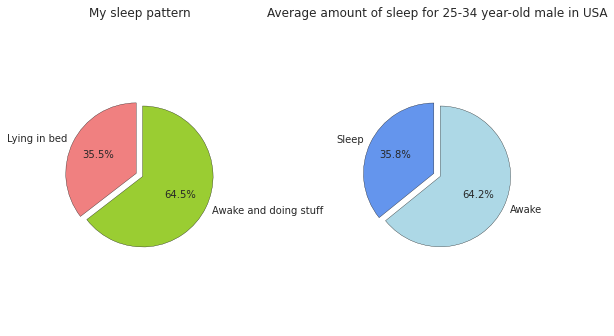

In [7]:

plt.rcParams['font.family'] = 'DejaVu Sans'
fig = plt.figure()

labels = 'Lying in bed', 'Awake and doing stuff'
sizes = [percent_in_bed*100.0, 100.0-percent_in_bed*100.0]
colors = ['lightcoral', 'yellowgreen']
explode = (0.1, 0)

fig.add_subplot(121)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('My sleep pattern')



labels = 'Sleep', 'Awake'
sizes = [8.6/24.0*100.0, 100.0-(8.6/24.0*100.0)]
colors = ['cornflowerblue', 'lightblue']
explode = (0.1, 0) 

fig.add_subplot(122)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Average amount of sleep for 25-34 year-old male in USA')

plt.gcf().subplots_adjust(hspace=1,wspace=1)
plt.show()

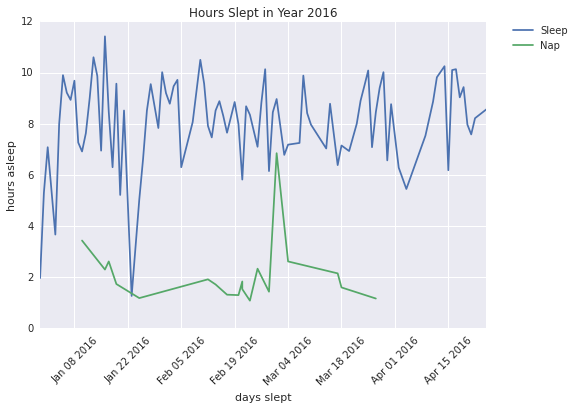

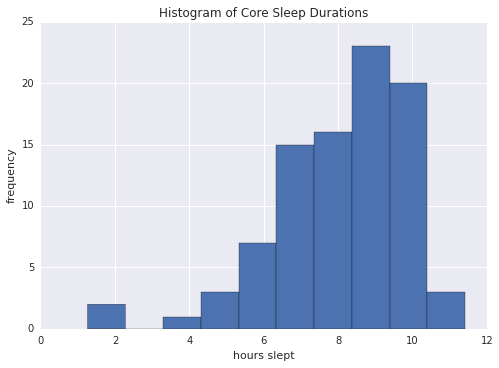

In [8]:
from matplotlib.dates import DateFormatter
from datetime import datetime

durations = sqlContext.sql("""
    SELECT sleep.dateOfSleep,
           sleep.duration / 1000 / 60 / 60 as duration
           -- sleep.awakeDuration / 1000 / 60 / 60 as awakeDuration,
           -- sleep.restlessDuration / 1000 / 60 / 60 as restlessDuration
    FROM sleeps
    WHERE sleep.isMainSleep = TRUE
""")

dates = durations.select('dateOfSleep').toPandas()
dates = [ datetime.strptime(d[0], '%Y-%m-%d') for d in dates.values ]

duration = durations.select('duration').toPandas()
#awake_duration = durations.select('awakeDuration').toPandas()
#restless_duration = durations.select('restlessDuration').toPandas()

nap_duration = sqlContext.sql("""
    SELECT sleep.dateOfSleep,
           sleep.duration / 1000 / 60 / 60 as duration
    FROM sleeps
    WHERE sleep.isMainSleep = FALSE
""")

nap_dates = nap_duration.select('dateOfSleep').toPandas()
nap_dates = [ datetime.strptime(d[0], '%Y-%m-%d') for d in nap_dates.values ]
nap_duration = nap_duration.select('duration').toPandas()

fig, ax = plt.subplots()
ax.fmt_xdata = DateFormatter('%Y-%m-%d')

s1, = ax.plot(dates, duration, label='duration')
#s2, = ax.plot(dates, awake_duration, label='awake')
#s3, = ax.plot(dates, restless_duration, label='restless')
s4, = ax.plot(nap_dates, nap_duration, label='nap')

ax.legend([s1,s4],
          ['Sleep', 'Nap'],
          bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel('hours asleep')
ax.set_xlabel('days slept')

locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Hours Slept in Year 2016')

plt.show()



n, bins, patches = plt.hist(duration.values, label='duration')

plt.xlabel('hours slept')
plt.ylabel('frequency')
plt.title('Histogram of Core Sleep Durations')

plt.show()


In [10]:
max_sleep = sqlContext.sql("""
    SELECT MAX(sleep.duration / 1000 / 60 / 60) as duration
    FROM sleeps
""")

print "The longest I've slept is {0:.2f} hours".format(max_sleep.collect()[0]['duration'])

The longest I've slept is 11.42 hours
